In [1]:
!sudo apt-get update -y
!sudo apt-get install python3.9


!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

!python --version

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,027 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,590 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Pack

In [2]:
!pip3 install darts -q
!pip3 uninstall statsmodels -y
!pip3 install numpy scipy patsy pandas
!pip3 install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━

# 1. Imports

## 1.1 Bibliotecas

In [37]:
import pickle
import pandas as pd

import numpy as np

from tqdm.notebook import tqdm
import warnings

from numpy.linalg import LinAlgError
from statsmodels.tools.sm_exceptions import *

from darts.models.forecasting.auto_arima import AutoARIMA
from darts.models.forecasting.arima import ARIMA
import seaborn as sns 
import matplotlib.pyplot as plt 

from datetime import datetime
from itertools import product
import time
from unicodedata import normalize

from darts import TimeSeries, concatenate
from darts.datasets import AustralianTourismDataset
from darts.metrics import mae
from darts.dataprocessing.transformers import MinTReconciliator
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
from darts.models.forecasting.xgboost import XGBModel
from darts.metrics import rmse
from darts.models.forecasting.random_forest import RandomForest
from darts.metrics import mape
from darts.metrics import coefficient_of_variation as coef_var

In [4]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

## 1.2 Dados

df_final: DataFrame Principal

hierarchy: Hierarquia principal

ts_all: Série temporal completa

In [5]:
with open('/content/drive/MyDrive/Dados/standarized/hierarchy/hierarchy_02-04-2023.pkl', 'rb') as fp:
    hierarchy = pickle.load(fp)
with open('/content/drive/MyDrive/Dados/standarized/dict_plot/dict_plot_02-04-2023.pkl', 'rb') as fp:
    dict_plot = pickle.load(fp)

In [6]:
# Data utilizada: 21/03/2023
df_final = pd.read_csv('/content/drive/MyDrive/Dados/standarized/time_series/time_series_02-04-2023.csv')
# Time_series para iterções;
ts_all = TimeSeries.from_dataframe(df =df_final, time_col= 'ano', value_cols=df_final.columns.drop('ano'), hierarchy=hierarchy)

# 2. Funções

In [7]:
# Utilizar o acelerador de GPU do colab (para treinamento)
import tensorflow as tf

def GPU_colab():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print('GPU device not found')
    else:
        print('Found GPU at: {}'.format(device_name))
        tf.device('/device:GPU:0')
        print()
        ##
        physical_devices = tf.config.experimental.list_logical_devices('GPU')
        #rint("GPUs available: ", physical_devices)
        print("GPUs available: ", len(physical_devices))
        print(physical_devices[0].name)
        print()

        # Qual placa de video GPU estou usando?
        from tensorflow.python.client import device_lib
        device_lib.list_local_devices()
        print(device_lib.list_local_devices())

In [8]:
# Retorna o dia atual (Para salvamento de arquivos e controle de versões)
def today():
    return time.strftime("%d-%m-%Y", time.localtime()) 

In [9]:
# Grid Searh Model
def gridsearch_Model(time_series, baseline_model, grid_parameters, n=None):
    """
    # Receber:

    * time_series [TimeSeries] -> Série temporal completa;
    * baseline_model [Object] -> Modelo para realizar GS, exemplo: ARIMA, AutoARIMA;
    * parameters[parameters] -> Parâmetros do modelo para pesquisa.

    # Retorna:

    Função retorna uma lista contendo os seguintes objetos:

    * Objeto de modelo [object]: Modelo que será usado para predições, historical_forecasts e outros...
    * Parâmetros [dict]: Área de parametrização que irá encontrar a melhor combinação de parâmetros em um intervalo definido.
    * Métrica RMSE [float]: Métrica de Erro, RMSE
    * Nome do modelo [str]: Nome textual do modelo.
    """
    name_model = str(baseline_model().__class__).split('.')[-1].replace("'", "").replace('>','')
    save_name_model = name_model +"_"+ today() 

    model_tuple = baseline_model.gridsearch(
        parameters = grid_parameters, 
        series = time_series, 
        forecast_horizon = 1, 
        start = 0.885, #Começa apartir do dia correspondente ao valor de 11% da serie # WORKOUT_DAYS_SLICED * 3, 
        stride = 1,# 1
        metric = rmse,
        n_jobs = -1
        )
    
    
    return [model_tuple[0], model_tuple[1], model_tuple[2], name_model]


## Teste

In [14]:
parameters = {
'p': list(range(0,3)),
'd': list(range(0,3)),
'q': list(range(0,3)),
'seasonal_order':[[0,1,1,6],
                  [0,1,1,12],
                  [0,1,1,3]]
}

In [65]:
def train_predict(df, baseline_model, parameters_model):

    """
    # Recebe:

    * df[Pandas.DataFrame]: DataFrame Pandas com todas as variáveis
    * baseline_model: Modelo base, ex: ARIMA
    * parameters: Parâmetros de pesquisa do GridSearch

    # Retorna: 

    * score[dict]: Dicionário com pontuações
    * predict_ts[TimeSeries]: Objeto darts com predições;
    """

    # Forecast_ts: Lista para iteração
    forecast_ts = list()
    # score: Lista para iteração de pontuações.
    score = dict()
    score_coef_var = dict()
    # hisForecast_list: Lista para iteração 
    histForecast_list = list()
    forecast_parameters = dict()

    params = list()
#
    for i, j in zip(df.columns, tqdm(range(len(df.columns)))):
        # Dá de melhorar isso aq:
        
        if i != 'ano':
            time_series = TimeSeries.from_dataframe(df =df[[i, 'ano']], time_col= 'ano', value_cols=i)
            
            try:    
                model = gridsearch_Model(time_series, baseline_model, grid_parameters = parameters_model)
                model[0].fit(time_series)

                forecast = model[0].predict(5, series=time_series)
                historical_forecast = model[0].historical_forecasts(time_series, start = 0.885, forecast_horizon=1,
                                                                            stride=1, retrain=False, last_points_only=True)
                score[i] = model[2]
                params_with_name = model[1]
                params_with_name['seasonal_order'] = str(params_with_name['seasonal_order'])
                params_with_name['date'] = today()
                print(params_with_name)
                params.append(pd.DataFrame(params_with_name, index=[i]))

                print(f'Coluna {i} gerou RMSE de: {score[i]}')

            except(LinAlgError) as e:
                print(f'[ERRO]: Ocorreu o erro {e} na coluna {i}')
                model = gridsearch_Model(time_series, AutoARIMA, grid_parameters = {})
                model[0].fit(time_series)
                forecast = model[0].predict(5)
                historical_forecast = model[0].historical_forecasts(time_series, start = 0.885, forecast_horizon=1,
                                                                            stride=1, retrain=True, last_points_only=True)
                score[i] = model[2]
                params_with_name = model[1]
                params_with_name['date'] = today()
                print(params_with_name)
                params.append(pd.DataFrame(params_with_name, index=[i]))
                
                print(f'Coluna {i} gerou RMSE de: {score[i]}')
                
                            
            score_coef_var[i] = coef_var(time_series[[i]], historical_forecast)
            forecast_ts.append(forecast.pd_dataframe())
            histForecast_list.append(historical_forecast.pd_dataframe())

            
                

    histForecast_df = pd.concat(histForecast_list,axis=1).reset_index().rename(columns ={'time':'ano'}).rename(columns ={'index':'ano'})
    params_df = pd.concat(params,axis=0).rename_axis('var').reset_index()
    histForecast_ts = TimeSeries.from_dataframe(df =histForecast_df, time_col= 'ano', value_cols=histForecast_df.columns.drop('ano'))

    pred_last_4_year = histForecast_df.loc[histForecast_df['ano']>=2017]
        
    # Predict

    predict_df =  pd.concat(forecast_ts, axis=1).reset_index()

    predict_df =  pd.concat([predict_df, pred_last_4_year]).reset_index(drop=True)

    predict_ts = TimeSeries.from_dataframe(df =predict_df, time_col= 'ano', value_cols=predict_df.columns.drop('ano'))

        
        
    predict_df.to_csv(f'/content/drive/MyDrive/Dados/standarized/forecast_ts/{today()}.csv', index=False)
    # Score
    params_df.to_csv(f'/content/drive/MyDrive/Dados/standarized/parametros/{today()}.csv', index=False)

    pd.DataFrame(score_coef_var, index=[today()]).to_csv(f'/content/drive/MyDrive/Dados/standarized/score/COEF/{today()}.csv', index=True)
    pd.DataFrame(score, index=[today()]).to_csv(f'/content/drive/MyDrive/Dados/standarized/score/RMSE/{today()}.csv', index=True)

        
    # Historical Forecast
        

    histForecast_df.to_csv(f'/content/drive/MyDrive/Dados/standarized/historical_forecast/{today()}.csv', index=False)
        

    return score, score_coef_var, predict_ts


score_arima,score_arima_coef_var, predict_arima = train_predict(df_final, ARIMA, parameters)

  0%|          | 0/62 [00:00<?, ?it/s]

{'p': 0, 'd': 2, 'q': 0, 'seasonal_order': '[0, 1, 1, 3]', 'date': '03-04-2023'}
Coluna VAR_EFETIVO_DOS_REBANHOS gerou RMSE de: 304478.3811936279
{'p': 0, 'd': 2, 'q': 0, 'seasonal_order': '[0, 1, 1, 3]', 'date': '03-04-2023'}
Coluna VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO gerou RMSE de: 304478.3818387936
{'p': 2, 'd': 1, 'q': 1, 'seasonal_order': '[0, 1, 1, 12]', 'date': '03-04-2023'}
Coluna VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BELEM gerou RMSE de: 13575.62971911529
{'p': 1, 'd': 1, 'q': 2, 'seasonal_order': '[0, 1, 1, 12]', 'date': '03-04-2023'}
Coluna VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BELEM - REGIMED_ABAETETUBA gerou RMSE de: 10874.664824814221
{'p': 0, 'd': 1, 'q': 0, 'seasonal_order': '[0, 1, 1, 6]', 'date': '03-04-2023'}
Coluna VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BELEM - REGIMED_BELEM gerou RMSE de: 12691.468824825826
{'p': 0, 'd': 1, 'q': 0, 'seasonal_order': '[0, 1, 1, 3]', 'date': '03-04-2023'}
Coluna VAR_EFETIVO_DOS_REBANH

# 4. Gráficos (Demo)

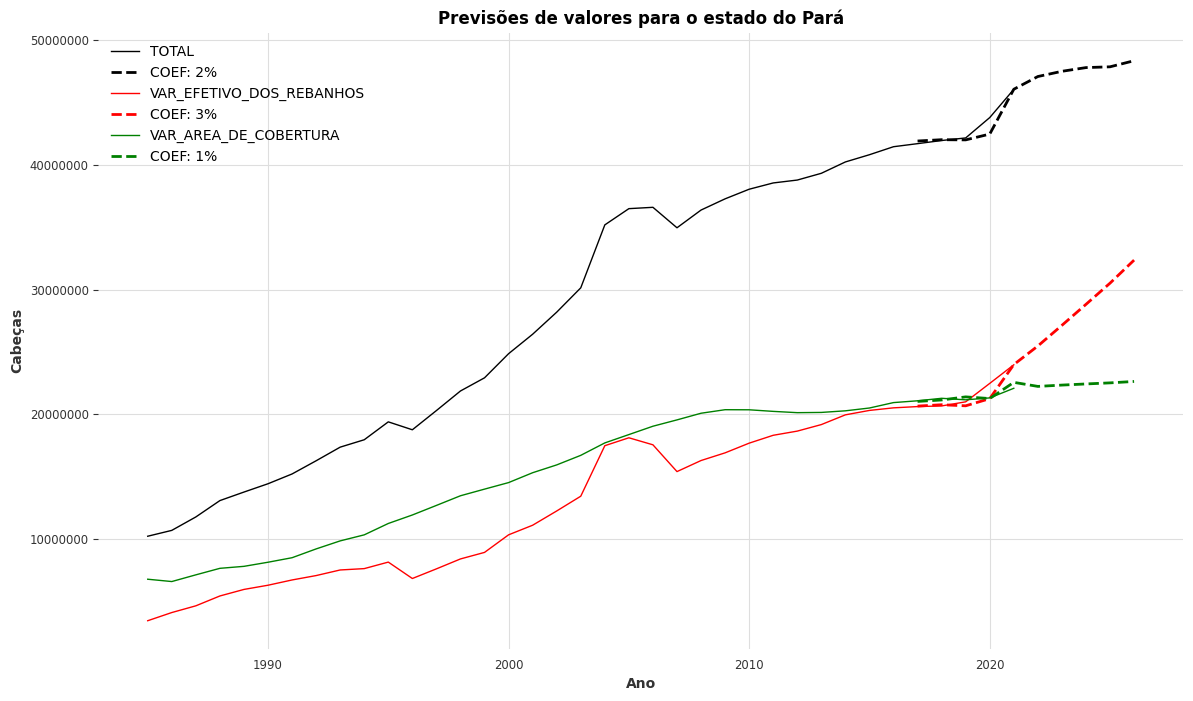

In [66]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='TOTAL'
# ----------------------


score_main_var = round(float(score_arima_coef_var[main_var]))

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')


for i,j in zip(dict_plot[main_var], colors):
    try:
        try:
            score_i = round(int(score_arima_coef_var[i]),2)
        except:
            score_i = score_arima_coef_var[i]
        
        ts_all[i].plot(lw=1, label = f'{i}', color = j)
        predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

        plt.title('Previsões de valores para o estado do Pará', fontweight="bold", fontsize=12)
        plt.ylabel('Cabeças')
        plt.xlabel('Ano')
    except KeyError:
        pass

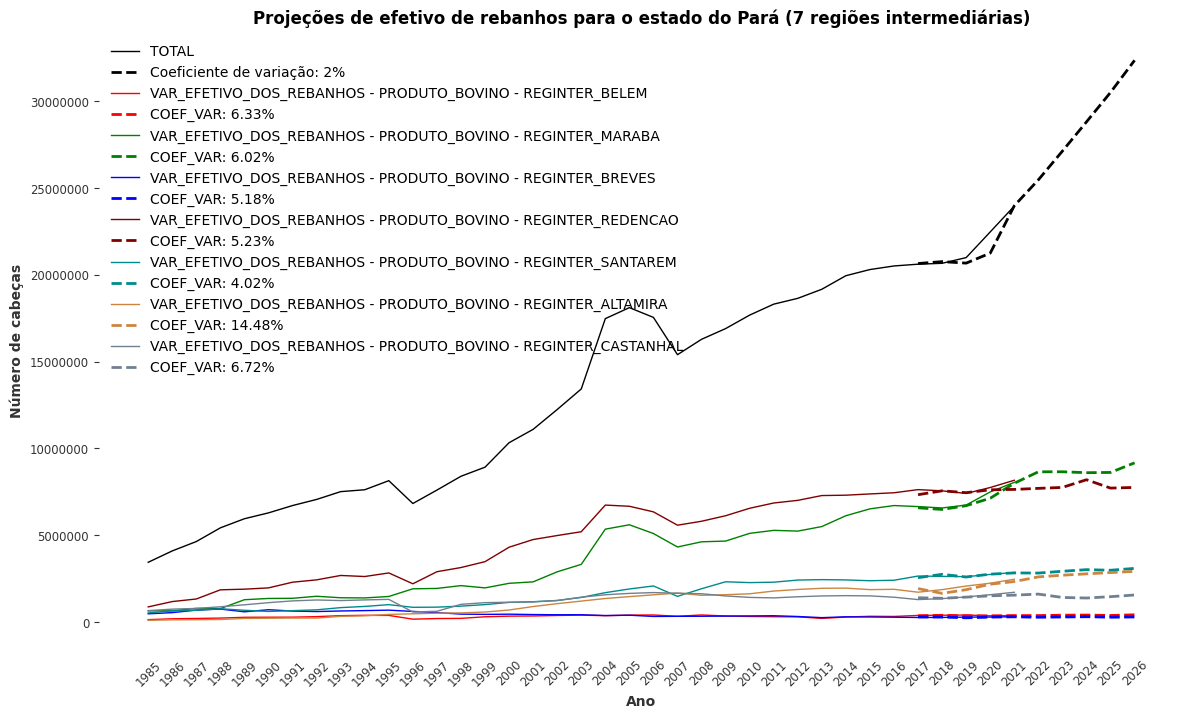

In [67]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO'
# ----------------------


#score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'Coeficiente de variação: {score_main_var}%', color = 'black', linestyle='--')


for i,j in zip(dict_plot[main_var], colors):
    try:
        score_i = round(score_arima_coef_var[i],2)
        
        ts_all[i].plot(lw=1, label = f'{i}', color = j)
        predict_arima[i].plot(lw=2,label =f'COEF_VAR: {score_i}%', color = j, linestyle='--')

        plt.title('Projeções de efetivo de rebanhos para o estado do Pará (7 regiões intermediárias)', fontweight="bold", fontsize=12)
        plt.xticks(list(range(1985,2027)), rotation=45)
        plt.ylabel('Número de cabeças')
        plt.grid(False)
        plt.xlabel('Ano')
    except KeyError:
        pass
    # Somar castanhal belem e breves

Text(0.5, 0, 'Ano')

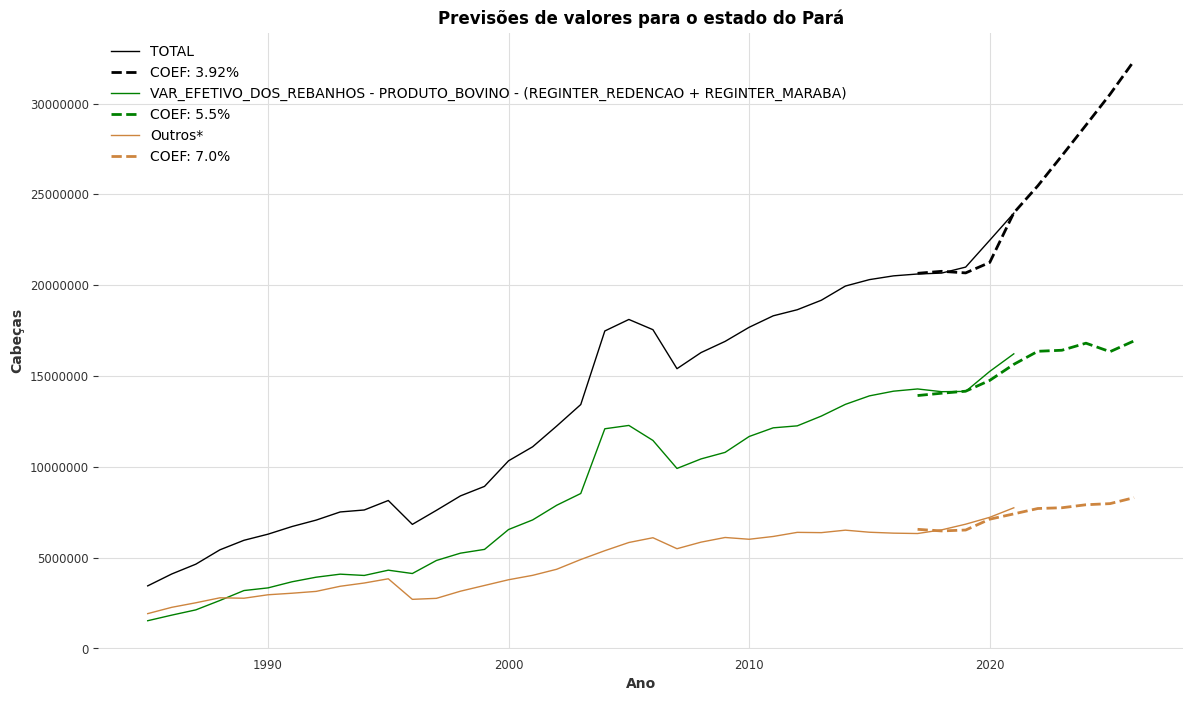

In [68]:

plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO'
columns_to_plot = ['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_REDENCAO', 'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_MARABA']
# ----------------------

score_other=list()
score_REGINTER_REDENCAO_REGINTER_MARABA=list()
later_plot = list()
early_plot=list()

score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')



for i,j in zip(dict_plot[main_var], colors):
    if i in columns_to_plot:
        try:
            try:
                score_i = round(int(score_arima_coef_var[i]),2)
            except:
                score_i = score_arima_coef_var[i]
        
            score_REGINTER_REDENCAO_REGINTER_MARABA.append(score_i)
            early_plot.append(i)
        except KeyError:
            pass
    else:
        try:
            score_i = round(int(score_arima_coef_var[i]),2)
        except:
                try:
                    score_i = round(int(score_arima_coef_var[i]),2)
                except:
                    score_i = 0
        later_plot.append(i)
        score_other.append(score_i)

score_mean_REGINTER_REDENCAO_REGINTER_MARABA = round(sum(score_REGINTER_REDENCAO_REGINTER_MARABA) / len(score_REGINTER_REDENCAO_REGINTER_MARABA),2)
score_mean = round(sum(score_other) / len(score_other),2)


ts_all[early_plot].sum(axis=1).plot(lw=1, label = f'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - (REGINTER_REDENCAO + REGINTER_MARABA)', color = 'g')
predict_arima[early_plot].sum(axis=1).plot(lw=2,label =f'COEF: {score_mean_REGINTER_REDENCAO_REGINTER_MARABA}%', color = 'g', linestyle='--')

ts_all[later_plot].sum(axis=1).plot(lw=1, label = f'Outros*', color = 'peru')
predict_arima[later_plot].sum(axis=1).plot(lw=2,label =f'COEF: {score_mean}%', color = 'peru', linestyle='--')

 

plt.title('Previsões de valores para o estado do Pará', fontweight="bold", fontsize=12)
plt.ylabel('Cabeças')
plt.xlabel('Ano')

KeyError: ignored

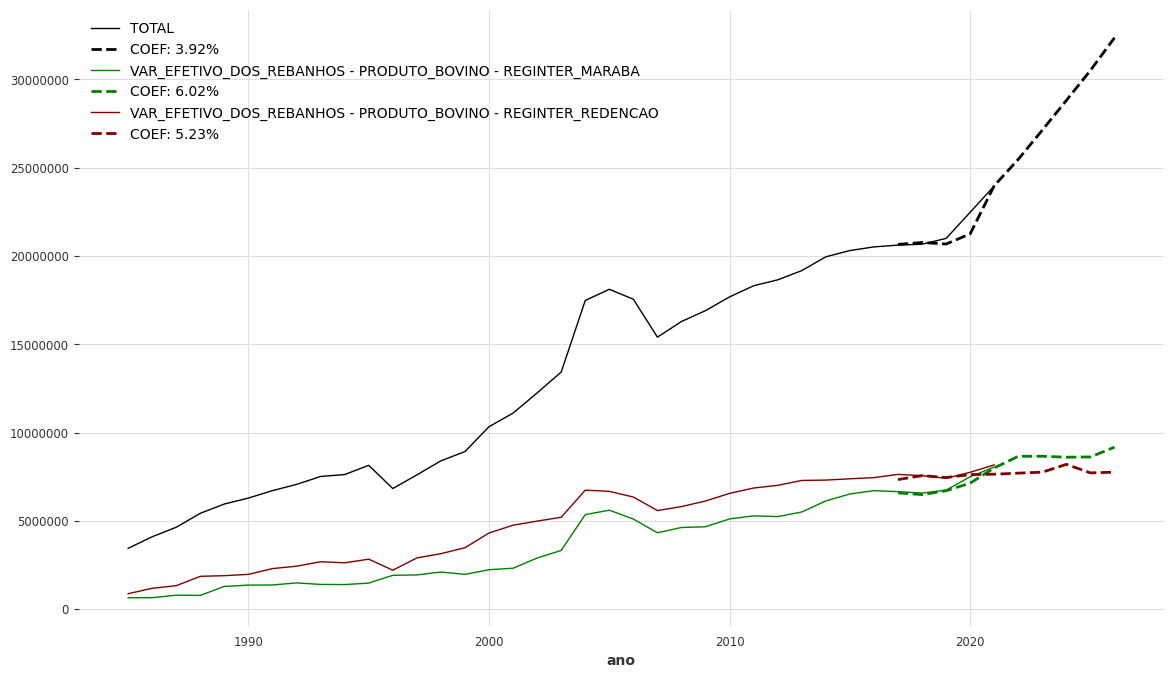

In [ ]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO'
columns_to_plot = ['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_REDENCAO', 'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_MARABA']
# ----------------------

pivot_ts = list()
predict_pivot_ts = list()
later_plot = list()

score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')

score_other=list()

for i,j in zip(dict_plot[main_var], colors):
    if i in columns_to_plot:
        try:
            score_i = round(score_arima_coef_var[i],2)
            
            ts_all[i].plot(lw=1, label = f'{i}', color = j)
            predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

            
        except KeyError:
            pass
    else:
        score_i = round(score_arima_coef_var[i],2)
        later_plot.append(i)
        pivot_ts.append(ts_all[i].pd_dataframe().reset_index(drop=True))
        predict_pivot_ts.append(predict_arima[i].pd_dataframe().reset_index(drop=True))

        score_other.append(score_i)




score_mean = sum(score_other) / len(score_other)
score_mean = round(score_mean,2)

ts_ano = ts_all['TOTAL'].pd_dataframe().reset_index()['ano']
pred_ano = predict_arima['TOTAL'].pd_dataframe().reset_index()['ano']

pivot_ts = pd.concat(pivot_ts, axis=1)
predict_pivot_ts = pd.concat(predict_pivot_ts, axis=1)

pivot_ts['ano'] = ts_ano.astype('int64')
predict_pivot_ts['ano'] = pred_ano.astype('int64')

pivot_ts = TimeSeries.from_dataframe(df =pivot_ts, time_col= 'ano')
predict_pivot_ts = TimeSeries.from_dataframe(df = predict_pivot_ts, time_col= 'ano')

pivot_ts.sum(axis=1).plot(lw=1, label = f'Outros*', color = 'peru')
predict_pivot_ts.sum(axis=1).plot(lw=2,label =f'COEF: {score_mean}%', color = 'peru', linestyle='--')

 

plt.title('Previsões de valores para o estado do Pará', fontweight="bold", fontsize=12)
plt.ylabel('Cabeças')
plt.xlabel('Ano')

In [ ]:
(score_arima['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BELEM'] + score_arima['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BREVES'] )/2

16273.503790431489

VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_SANTAREM
VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_ALTAMIRA
VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_CASTANHAL


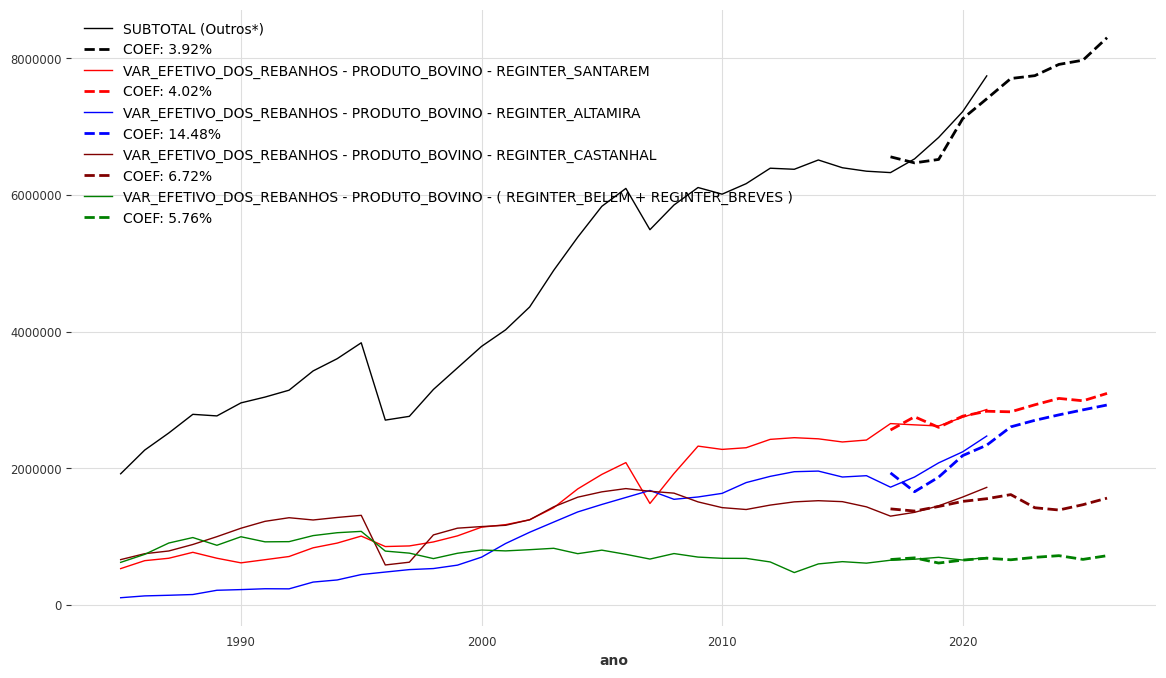

In [69]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['slategray', 'g','r', 'b', 'maroon', 'darkcyan', 'peru']

#---------------------------
no_plot=['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BELEM',
         'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BREVES']

#---------------------------
score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[later_plot].sum(axis=1).plot(lw=1, label = 'SUBTOTAL (Outros*)', color = 'black')
predict_arima[later_plot].sum(axis=1).plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')


score_other = list()


for i,j in zip(later_plot, colors):
    if i not in no_plot:
        try:
            print(i)
            score_i = round(score_arima_coef_var[i],2)
            
            ts_all[i].plot(lw=1, label = f'{i}', color = j)
            predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

            plt.title('Previsões de valores para o estado do Pará', fontweight="bold", fontsize=12)
            plt.ylabel('Cabeças')
            plt.xlabel('Ano')   
        except KeyError:
            pass
    else:
        score_i = round(score_arima_coef_var[i],2)
        score_other.append(score_i)

score_other = round(sum(score_other)/len(score_other),2)

ts_all[no_plot].sum(axis=1).plot(lw=1, label = 'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - ( REGINTER_BELEM + REGINTER_BREVES )', color = 'g')
predict_arima[no_plot].sum(axis=1).plot(lw=2,label =f'COEF: {score_other}%', color = 'g', linestyle='--')

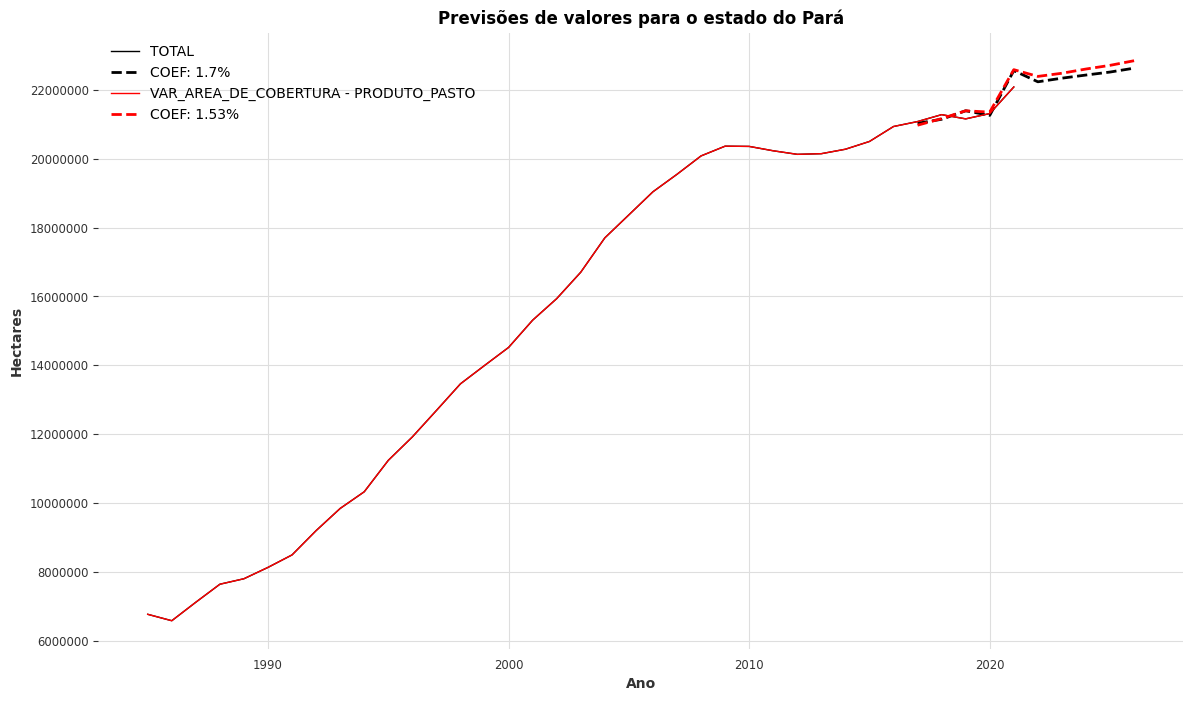

In [ ]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_AREA_DE_COBERTURA'
# ----------------------

score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[main_var].plot(lw=1, label = 'TOTAL ', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')


for i,j in zip(dict_plot[main_var], colors):
    try:
        score_i = round(score_arima_coef_var[i],2)
        
        ts_all[i].plot(lw=1, label = f'{i}', color = j)
        predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

        plt.title('Previsões de valores para o estado do Pará', fontweight="bold", fontsize=12)
        plt.ylabel('Hectares')
        plt.xlabel('Ano')
    except KeyError:
        pass

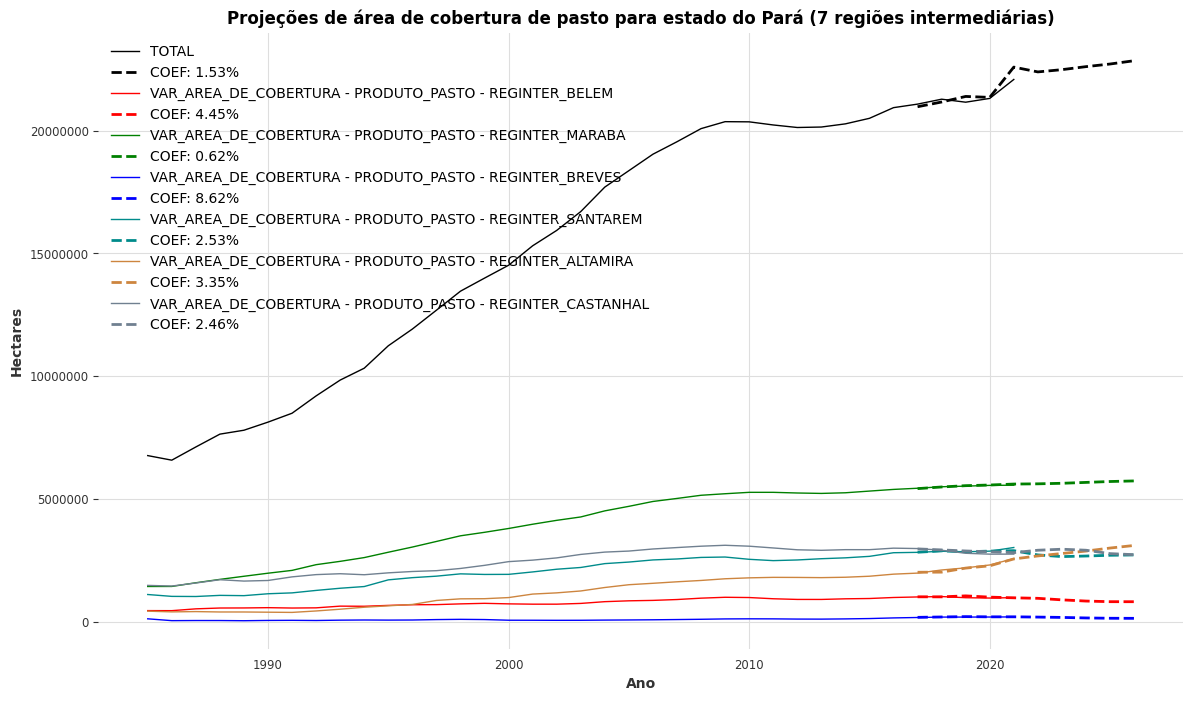

In [ ]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_AREA_DE_COBERTURA - PRODUTO_PASTO'
# ----------------------

score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')


for i,j in zip(dict_plot[main_var], colors):
    try:
        score_i = round(score_arima_coef_var[i],2)
        
        ts_all[i].plot(lw=1, label = f'{i}', color = j)
        predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

        plt.title('Projeções de área de cobertura de pasto para estado do Pará (7 regiões intermediárias)', fontweight="bold", fontsize=12)
        plt.ylabel('Hectares')
        plt.xlabel('Ano')
    except KeyError:
        pass
    # Breves e Belém -> Unir

In [ ]:
dict_plot['VAR_AREA_DE_COBERTURA - PRODUTO_SOJA_EM_GRAO']

KeyError: ignored

KeyError: ignored

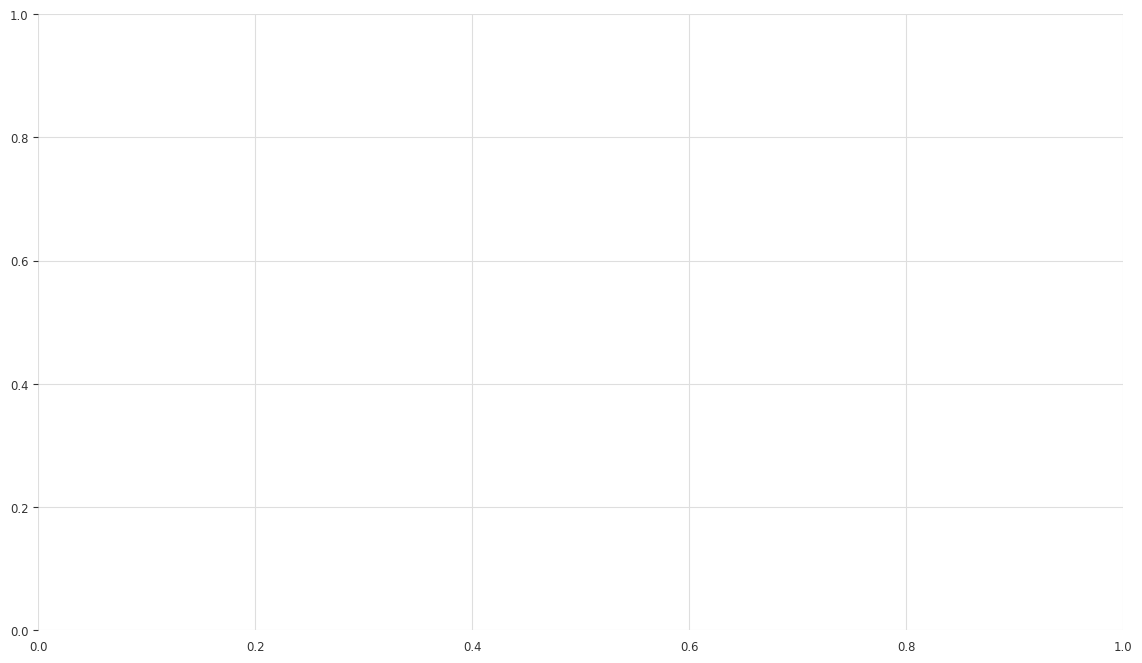

In [ ]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_AREA_DE_COBERTURA - PRODUTO_SOJA_EM_GRAO'
# ----------------------

score_main_var = round(score_arima_coef_var[main_var],2)

excluded = []

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')


for i,j in zip(dict_plot[main_var], colors):
    try:
        if i not in []:
            score_i = round(score_arima_coef_var[i],2)
            
            ts_all[i].plot(lw=1, label = f'{i}', color = j)
            predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

            plt.title('Projeções de área de cobertura de Soja para estado do Pará (7 regiões intermediárias)', fontweight="bold", fontsize=12)
            plt.ylabel('Hectares')
            plt.xlabel('Ano')
    except KeyError:
        pass
        #Remove cinza e verde

KeyError: ignored

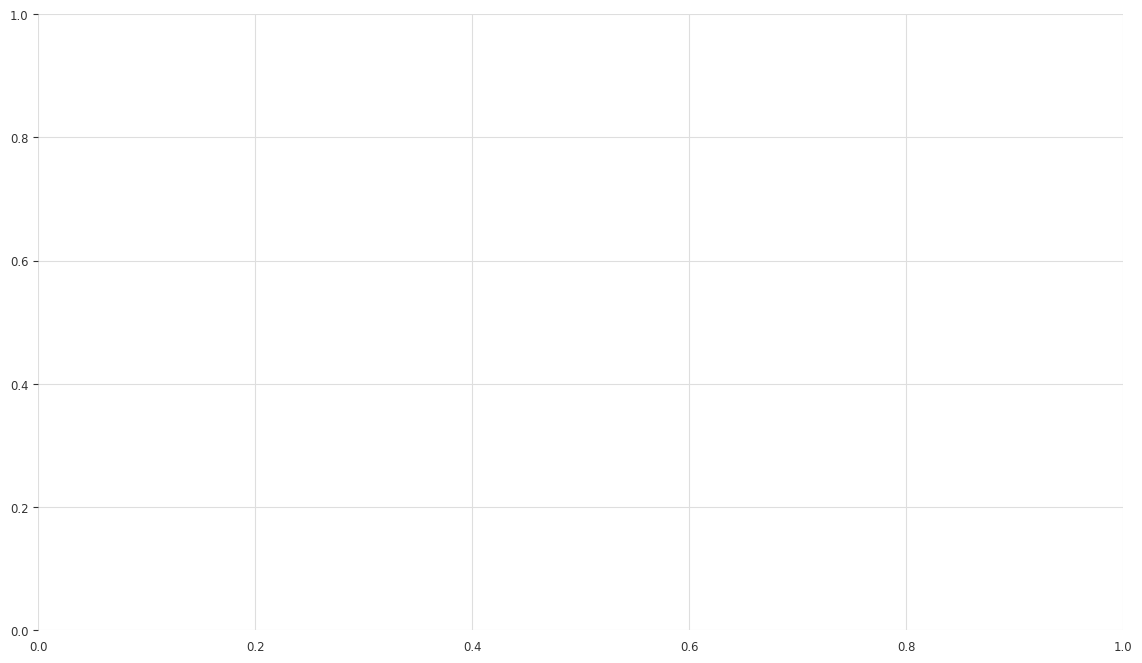

In [ ]:
plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

# ----------------------
main_var ='VAR_QUANTIDADE_PRODUZIDA - PRODUTO_SOJA_EM_GRAO'
# ----------------------
score_main_var = round(score_arima_coef_var[main_var],2)

ts_all[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
predict_arima[main_var].plot(lw=2,label =f'COEF: {score_main_var}%', color = 'black', linestyle='--')


for i,j in zip(dict_plot[main_var], colors):
    try:
        score_i = round(score_arima_coef_var[i],2)
        
        ts_all[i].plot(lw=1, label = f'{i}', color = j)
        predict_arima[i].plot(lw=2,label =f'COEF: {score_i}%', color = j, linestyle='--')

        plt.title('Projeções de quantidade produzida de soja para estado do Pará (7 regiões intermediárias)', fontweight="bold", fontsize=12)
        plt.ylabel('Quantidade (Toneladas)')
        plt.xlabel('Ano')
    except KeyError:
        pass